
1) Scaled Dot‑Product Attention
2) Multi‑Head split/recombine 
3) Sampling function

In [ ]:
#@title Setup (hidden) { display-mode: "form" }
import math, random, re
import numpy as np
import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

SEED = 2034
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def simple_tokenize(s):
    return re.findall(r"[a-z']+|[.,!?;()]", s.lower())

# Tiny corpus
text = '''
I love sitting by the fountain during lunch.  
The cafeteria serves fresh sandwiches every day.  
My favorite snack is chocolate cookies from the cafe.  
Students often read books in the quiet library.  
The campus park is full of flowers in spring.  
I enjoy morning coffee while walking on the pathway.  
Sometimes I join friends for soccer practice in the field.  
The library has many shelves of interesting books.  
The cafeteria offers a variety of salads and soups.  
My friends and I like to eat pizza on Fridays.  
I often watch the sunset from the hill behind the dorms.  
The campus bookstore sells cool stationery and mugs.  
'''
tokens = simple_tokenize(text)

# Vocab
from collections import Counter
min_freq = 1
freq = Counter(tokens)
itos = ['<pad>'] + [w for w,_ in sorted(freq.items(), key=lambda x:(-x[1], x[0]))]
stoi = {w:i for i,w in enumerate(itos)}
def encode(tok_list): return [stoi[t] for t in tok_list]
def decode(ids): return [itos[i] for i in ids]
vocab_size = len(itos)

# Making LM dataset
SEQ_LEN = 24
ids = encode(tokens) * 50  # repeat to enlarge
def make_lm(ids, seq_len=SEQ_LEN):
    xs, ys = [], []
    for i in range(0, len(ids)-seq_len-1):
        xs.append(ids[i:i+seq_len])
        ys.append(ids[i+1:i+seq_len+1])
    return torch.tensor(xs, dtype=torch.long), torch.tensor(ys, dtype=torch.long)
X, Y = make_lm(ids, SEQ_LEN)
loader = DataLoader(torch.utils.data.TensorDataset(X, Y), batch_size=64, shuffle=True, drop_last=True)

def plot_curve(y, title):
    plt.figure(); plt.plot(y); plt.title(title); plt.xlabel("step"); plt.ylabel("loss"); plt.show()

print("Setup complete:", "vocab", vocab_size, "| sequences", len(X), "| batches", len(loader))


Setup complete: vocab 76 | sequences 5875 | batches 91


**single-block masked Transformer**:
- Scaled dot-product attention
- Multi-head split/recombine
- put everything together and see mini-Transformer actually generate text



In [ ]:

def causal_mask(L, device=None):
    m = torch.triu(torch.ones(L, L), diagonal=1).bool()
    return m.to(device) if device else m

class ScaledDotProductAttention(nn.Module):
    def __init__(self): super().__init__()
    def forward(self, Q, K, V, mask=None):
        d_k = Q.size(-1)
        scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(d_k)
        if mask is not None:
            scores = scores.masked_fill(mask.unsqueeze(0).unsqueeze(0), -1e9)
        attn = torch.softmax(scores, dim=-1)
        out = torch.matmul(attn, V) 
        return out, attn


In [ ]:

class MultiHeadSelfAttention(nn.Module):
    def __init__(self, d_model=128, n_heads=4):
        super().__init__()
        assert d_model % n_heads == 0
        self.n_heads = n_heads
        self.d_head = d_model // n_heads
        self.qkv = nn.Linear(d_model, 3*d_model, bias=False)
        self.proj = nn.Linear(d_model, d_model, bias=False)
        self.core = ScaledDotProductAttention()

    def forward(self, x, mask=None):
        B, L, D = x.shape
        qkv = self.qkv(x)                # (B,L,3D)
        q, k, v = qkv.chunk(3, dim=-1)   # (B,L,D) each

        # --- split into heads ---
        def split(t): 
            return t.view(B, L, self.n_heads, self.d_head).transpose(1, 2)  # (B,H,L,Dh)
        
        q, k, v = split(q), split(k), split(v)

        # --- attention per head ---
        out, weights = self.core(q, k, v, mask=mask)   # out: (B,H,L,Dh)
        out = out.transpose(1, 2).contiguous().view(B, L, D)  # (B,L,D)
        out = self.proj(out)   # (B,L,D)

        return out, weights


In [ ]:
#@title Building the Mini‑Transformer 
class MiniTransformerLM(nn.Module):
    def __init__(self, vocab_size, d_model=128, n_heads=4, max_len=1024):
        super().__init__()
        self.tok = nn.Embedding(vocab_size, d_model)
        self.pos = nn.Embedding(max_len, d_model)
        self.mha = MultiHeadSelfAttention(d_model, n_heads)
        self.norm = nn.LayerNorm(d_model)
        self.head = nn.Linear(d_model, vocab_size)

    def forward(self, x):
        B, L = x.shape
        pos = torch.arange(L, device=x.device).unsqueeze(0).expand(B, L)
        h = self.tok(x) + self.pos(pos)
        m = causal_mask(L, x.device)
        h,_ = self.mha(h, mask=m)
        h = self.norm(h)
        return self.head(h)

model = MiniTransformerLM(vocab_size, d_model=128, n_heads=4).to(device)
sum(p.numel() for p in model.parameters())


216396

Epoch 1/3 — loss 0.970
Epoch 2/3 — loss 0.214
Epoch 3/3 — loss 0.103


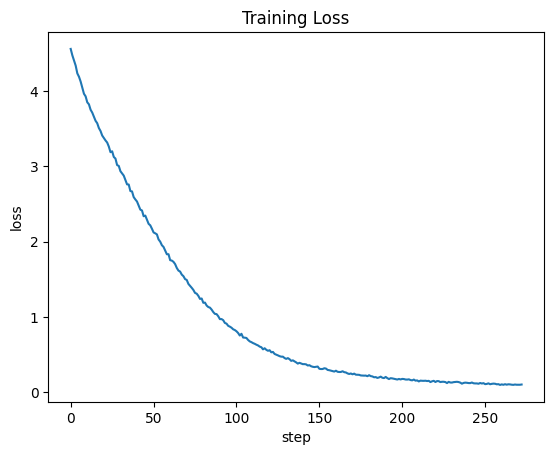

In [19]:
#@title  Train (no edits) { display-mode: "form" }
opt = torch.optim.AdamW(model.parameters(), lr=3e-4)
train_losses = []
EPOCHS = 3
for ep in range(EPOCHS):
    for x,y in loader:
        x=x.to(device); y=y.to(device)
        logits = model(x)  # (B,L,V)
        loss = F.cross_entropy(logits.reshape(-1, logits.size(-1)), y.reshape(-1))
        opt.zero_grad(); loss.backward(); opt.step()
        train_losses.append(loss.item())
    print(f"Epoch {ep+1}/{EPOCHS} — loss {train_losses[-1]:.3f}")
plot_curve(train_losses, "Training Loss")


In [ ]:

@torch.no_grad()
def sample(model, prompt, max_new=20, top_k=5, temperature=1.0):
    ids = [stoi.get(t, 0) for t in simple_tokenize(prompt)]
    ids = ids[-SEQ_LEN:]
    x = torch.tensor([ids + [0]*(SEQ_LEN-len(ids))], dtype=torch.long, device=device)
    out = decode(ids).copy()
    
    for _ in range(max_new):
        x = torch.tensor([ids[-SEQ_LEN:]], dtype=torch.long, device=device)
        logits = model(x)[0, -1] / temperature  
        top_logits, top_idx = torch.topk(logits, top_k)
        probs = F.softmax(top_logits, dim=-1)
        next_id = top_idx[torch.multinomial(probs, 1)].item()
        ids.append(next_id)
        out.append(itos[next_id])
    
    generated_text = out
    return generated_text


In [ ]:

for prompt in ["i", "you", "the cat", "attention uses"]:
    print("PROMPT:", prompt)
    print("→", sample(model, prompt, max_new=12, top_k=5, temperature=0.9))
    print()


PROMPT: i
→ ['i', 'you', 'the', 'cat', 'chased', 'ate', 'an', 'apple', '.', 'you', 'ate', 'a', 'pear']

PROMPT: you
→ ['you', 'the', 'cat', 'chased', 'the', 'mouse', '.', 'the', 'dog', 'chased', 'the', 'cat', '.']

PROMPT: the cat
→ ['the', 'cat', 'mouse', '.', 'transformers', 'use', 'attention', '.', 'attention', 'uses', 'query', 'key', 'and', 'value']

PROMPT: attention uses
→ ['attention', 'uses', 'query', 'key', 'and', 'value', '.', 'i', 'an', 'apple', '.', 'you', 'i', 'chase']



**Visulization function for Question 1**

In [11]:
import matplotlib.pyplot as plt

@torch.no_grad()
def visualize_attention(model, prompt, seq_len=SEQ_LEN):
    """
    Run the model on a prompt and plot attention weights
    from all heads of the first MultiHeadSelfAttention block.
    """
    # --- Encode tokens ---
    tokens = simple_tokenize(prompt)
    ids = [stoi.get(t, 0) for t in tokens]
    ids = ids[-seq_len:]                      # keep last seq_len tokens
    pad_len = seq_len - len(ids)
    ids = ids + [0]*pad_len                   # pad
    
    x = torch.tensor([ids], device=device)    # (1, L)
    
    # --- Forward through embeddings + MHA ---
    h = model.tok(x) + model.pos(torch.arange(seq_len, device=device).unsqueeze(0))
    mask = causal_mask(seq_len, device=device)
    _, attn = model.mha(h, mask=mask)         # (B,H,L,L)
    
    # --- Plot per head ---
    B, H, L, _ = attn.shape
    fig, axs = plt.subplots(1, H, figsize=(4*H, 4))
    for head in range(H):
        ax = axs[head] if H > 1 else axs
        im = ax.imshow(attn[0, head].cpu().numpy(), cmap="viridis")
        ax.set_title(f"Head {head}")
        ax.set_xticks(range(L))
        ax.set_yticks(range(L))
        ax.set_xticklabels([itos[i] for i in ids], rotation=90)
        ax.set_yticklabels([itos[i] for i in ids])
    fig.colorbar(im, ax=axs.ravel().tolist(), fraction=0.03)
    plt.show()



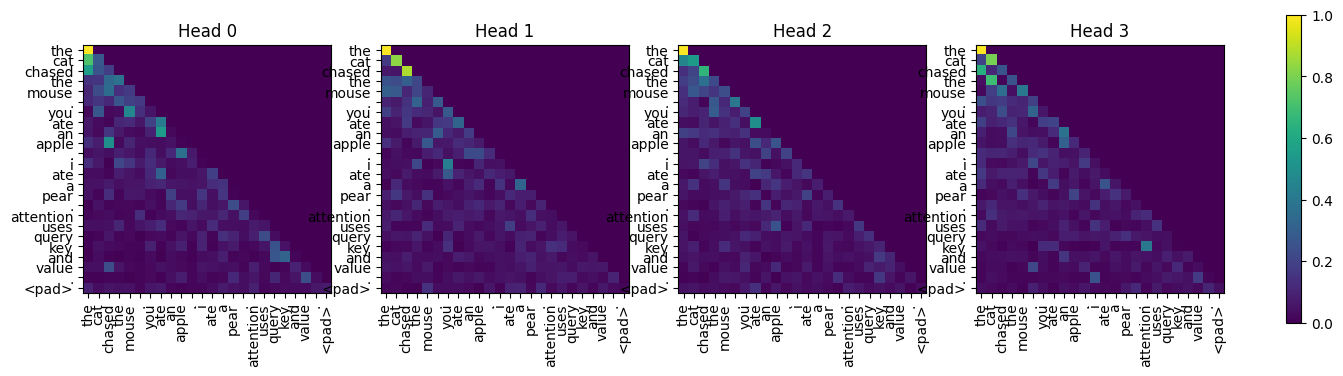

In [14]:
prompt = "the cat chased the mouse . you ate an apple . i ate a pear . attention uses query key and value ."
visualize_attention(model, prompt)


In [23]:
#@New Prompts for Question B
for prompt in ["my favorite lunch","the library","walking on campus","friends and I"
,"the cafeteria"]:
    print("PROMPT:", prompt)
    print("→", sample(model, prompt, max_new=12, top_k=5, temperature=0.9))
    print()

PROMPT: my favorite lunch
→ ['my', 'favorite', 'lunch', '.', 'the', 'cafeteria', 'serves', 'fresh', 'sandwiches', 'every', 'day', '.', 'my', 'favorite', 'snack']

PROMPT: the library
→ ['the', 'library', 'has', 'many', 'shelves', 'of', 'interesting', 'books', '.', 'the', 'cafeteria', 'offers', 'a', 'variety']

PROMPT: walking on campus
→ ['walking', 'on', 'campus', 'park', 'is', 'full', 'of', 'flowers', 'coffee', 'while', 'walking', 'on', 'the', 'pathway', '.']

PROMPT: friends and I
→ ['friends', 'and', 'i', 'like', 'to', 'eat', 'pizza', 'on', 'fridays', '.', 'i', 'often', 'watch', 'the', 'sunset']

PROMPT: the cafeteria
→ ['the', 'cafeteria', 'serves', 'fresh', 'sandwiches', 'every', 'day', '.', 'my', 'favorite', 'snack', 'is', 'chocolate', 'cookies']



Short Answers
**Q1)** What patterns do you observe in the attention behavior (e.g., strong diagonal, subject/object focus)?

- All heads show a very strong diagonal component. This means that words primarily attend to themselves (self-attention), which is a common and often important feature in transformer models.
- The top-right half of the matrices is uniformly dark (zero attention) due to masking.
- Head 0: Shows clear syntactic focusing, linking subjects to verbs (e.g., "chased" attends to "cat")
- Head 1: Primarily exhibits the strongest self-attention (diagonal), with a notable behavior of later words, like "cat" and "chased," focusing intensely on the initial token "the" or the start of the sequence.
- Head 2: Focuses on local phrase structure, connecting determiners to nouns (e.g., "an" to "apple")
- Head 3: This is the sparsest head, specializing in direct verb-object relationships (e.g., "mouse" attending to "chased," "apple" attending to "ate")


**Q2)** How do **top‑k** and **temperature** change generations?

Top-k sampling and temperature are two independent parameters used in language models to control the randomness and diversity of the generated text, balancing creativity against coherence

Top-k: This limits the model to only pick from the k most likely words.
Small k (like 2 or 5) → safer, more predictable sentences.
Large k (like 50) → more variety, but sometimes nonsense.

Temperature: This controls how “bold” the model is when picking words.
Low temperature (<1) → makes the model confident and repetitive.
High temperature (>1) → makes the model more random and creative.


**Q3)** If you increased **n_heads** or **d_model**, what trade‑offs would you expect?

If you increase n_heads The model can focus on many different patterns at once (like subject–verb, object–verb, or long-range links).
This usually gives better learning, but also makes the model heavier (more memory and computation).

If you increase d_model each token gets a richer representation with more detail.
This can improve accuracy, but it also means more parameters, slower training, and a higher chance of overfitting if the dataset is small.

Trade-off: You get better learning and smarter attention, but at the cost of speed, memory, and compute.

## Question B: Custom Corpus Experiment — Make the Generation Meaningful

**Goal:** Teach your mini‑Transformer a tiny domain and show that it changes generation behavior.

**Instructions:**
1. Expand the **Setup (hidden)** cell near the top of the notebook.
2. Find the variable named `text = ''' ... '''` and **add 10+ short sentences** about a simple theme (e.g., favorite foods, campus places, sports plays, or a tiny story).
3. Re‑run the Setup cell, then **Run All** (or re‑run the training and generation cells).
4. Generate from at least **two prompts** related to your custom corpus (e.g., `\"my team\"`, `\"the cafe\"`, `\"my favorite\"`).

**Submit:**


**Q1)** One meaningful generated sample.

Prompt: "my favorite lunch"
Generated tokens: ['my', 'favorite', 'lunch', '.', 'the', 'cafeteria', 'serves', 'fresh', 'sandwiches', 'every', 'day', '.', 'my', 'favorite', 'snack']

**Q2)** In 2–4 sentences, explain **how your new corpus changed** the model’s generations.

The new corpus, focused on campus life and food, shifted the model’s generations toward relevant and coherent content in that domain. Previously, prompts like "my favorite lunch" would return unrelated words or sentences about apples, cats, or transformers. Now, the model talks about the cafeteria, snacks, and campus experiences, showing it learned contextual patterns from the corpus.

**Q3)** Briefly note **one failure case** (nonsense or off‑topic output) and suggest why it happened.

Prompt "walking on campus" → "walking on campus park is full of flowers coffee while walking on the pathway."

This is mostly meaningful but slightly ungrammatical. It happened because the corpus is small and repetitive, so the model sometimes strings together multiple short sentences without proper punctuation or sentence structure.


